## Text classification using Neural Networks

The goal of this notebook is to learn to use Neural Networks for text classification.

In this notebook, we will:
- Train a shallow model with learning embeddings
- Download pre-trained embeddings from Glove
- Use these pre-trained embeddings

However keep in mind:
- Deep Learning can be better on text classification that simpler ML techniques, but only on very large datasets and well designed/tuned models.
- We won't be using the most efficient (in terms of computing) techniques, as Keras is good for prototyping but rather inefficient for training small embedding models on text.
- The following projects can replicate similar word embedding models much more efficiently: [word2vec](https://github.com/dav/word2vec) and [gensim's word2vec](https://radimrehurek.com/gensim/models/word2vec.html)   (self-supervised learning only), [fastText](https://github.com/facebookresearch/fastText) (both supervised and self-supervised learning), [Vowpal Wabbit](https://github.com/JohnLangford/vowpal_wabbit/wiki) (supervised learning).
- Plain shallow sparse TF-IDF bigrams features without any embedding and Logistic Regression or Multinomial Naive Bayes is often competitive in small to medium datasets.

## The BBC topic classification dataset

The BBC provides some benchmark topic classification datasets in English at: http://mlg.ucd.ie/datasets/bbc.html.

The raw text (encoded with the latin-1 character encoding) of the news can be downloaded as a ZIP archive:

In [2]:
import os
import os.path as op
import zipfile
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve


BBC_DATASET_URL = "http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip"
zip_filename = BBC_DATASET_URL.rsplit('/', 1)[1]
BBC_DATASET_FOLDER = 'bbc'
if not op.exists(zip_filename):
    print("Downloading %s to %s..." % (BBC_DATASET_URL, zip_filename))
    urlretrieve(BBC_DATASET_URL, zip_filename)

if not op.exists(BBC_DATASET_FOLDER):
    with zipfile.ZipFile(zip_filename, 'r') as f:
        print("Extracting contents of %s..." % zip_filename)
        f.extractall('.')

Each of the five folders contains text files from one of the five topics:

In [3]:
target_names = sorted(folder for folder in os.listdir(BBC_DATASET_FOLDER)
                      if op.isdir(op.join(BBC_DATASET_FOLDER, folder)))
target_names

['business', 'entertainment', 'politics', 'sport', 'tech']

Let's randomly partition the text files in a training and test set while recording the target category of each file as an integer:

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

target = []
filenames = []
for target_id, target_name in enumerate(target_names):
    class_path = op.join(BBC_DATASET_FOLDER, target_name)
    for filename in sorted(os.listdir(class_path)):
        filenames.append(op.join(class_path, filename))
        target.append(target_id)

target = np.asarray(target, dtype=np.int32)
target_train, target_test, filenames_train, filenames_test = train_test_split(
    target, filenames, test_size=200, random_state=0)

In [5]:
len(target_train), len(filenames_train)

(2025, 2025)

In [6]:
len(target_test), len(filenames_test)

(200, 200)

Let's check that text of some document have been loaded correctly:

In [7]:
idx = 0

with open(filenames_train[idx], 'rb') as f:
    print("class:", target_names[target_train[idx]])
    print()
    print(f.read().decode('latin-1')[:500] + '...')

class: business

Watchdog probes Vivendi bond sale

French stock market regulator AMF has filed complaints against media giant Vivendi Universal, its boss and another top executive.

It believes the prospectus for a bond issue was unclear and that executives may have had privileged information. AMF has begun proceedings against Vivendi, its chief executive Jean-Rene Fourtou and chief operating officer Jean-Bernard Levy. Vivendi advisor Deutsche Bank was also the subject of a complaint filing. Deutsche Bank, whic...


In [8]:
size_in_bytes = sum([len(open(fn, 'rb').read()) for fn in filenames_train])
print("Training set size: %0.3f MB" % (size_in_bytes / 1e6))

Training set size: 4.582 MB


This dataset is small so we can preload it all in memory once and for all to simplify the notebook.

In [9]:
texts_train = [open(fn, 'rb').read().decode('latin-1') for fn in filenames_train]
texts_test = [open(fn, 'rb').read().decode('latin-1') for fn in filenames_test]

## A first baseline model

For simple topic classification problems, one should always try a simple method first. In this case a good baseline is extracting TF-IDF normalized bag of bi-grams features and then use a simple linear classifier such as logistic regression.

It's a very efficient method and should give us a strong baseline to compare our deep learning method against.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


text_classifier = make_pipeline(
    TfidfVectorizer(min_df=3, max_df=0.8, ngram_range=(1, 2)),
    LogisticRegression(),
)

In [11]:
%time _ = text_classifier.fit(texts_train, target_train)

CPU times: total: 4.19 s
Wall time: 4.05 s


In [12]:
text_classifier.score(texts_test, target_test)

0.97

6 classification errors on 200 test documents for a model fit in less than 10s. It's quite unlikely that we can significantly beat that baseline with a more complex deep learning based model. However let's try to reach a comparable level of accuracy with Embeddings-based models just for teaching purpose.

### Preprocessing text for the (supervised) CBOW model

We will implement a simple classification model in Keras. Raw text requires (sometimes a lot of) preprocessing.

The following cells uses Keras to preprocess text:
- using a tokenizer. You may use different tokenizers (from scikit-learn, NLTK, custom Python function etc.). This converts the texts into sequences of indices representing the `20000` most frequent words
- sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length `1000`)
- we convert the output classes as 1-hot encodings

In [13]:
from keras.preprocessing.text import Tokenizer

MAX_NB_WORDS = 20000

# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 30995 unique tokens.


Tokenized sequences are converted to list of token ids (with an integer code):

In [14]:
sequences[0][:10]

[1857, 9454, 5251, 1973, 452, 543, 577, 121, 3073, 9455]

The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted to reconstruct the original message (without formatting):

In [15]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 30995)

In [16]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [17]:
" ".join([index_to_word[i] for i in sequences[0]])

"watchdog probes vivendi bond sale french stock market regulator amf has filed complaints against media giant vivendi universal its boss and another top executive it believes the prospectus for a bond issue was unclear and that executives may have had privileged information amf has begun proceedings against vivendi its chief executive jean rene fourtou and chief operating officer jean bernard levy vivendi advisor deutsche bank was also the subject of a complaint filing deutsche bank which was responsible for selling the convertible bonds to investors could face penalties if the complaint is upheld vivendi has said it believes there is no legal basis for the complaints the watchdog is said to believe the executive pair were party to privileged information surrounding the issue of the bonds both men bought some of the bonds the associated press news agency reported amf is investigating claims that the duo were aware of an interest in vivendi's us assets from investor marvin davis at the 

Let's have a closer look at the tokenized sequences:

In [18]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 382.6
max length: 4355


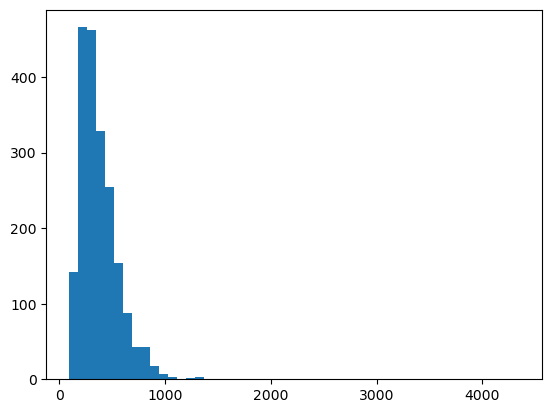

In [19]:
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50);

Let's zoom on the distribution of regular sized posts. The vast majority of the posts have less than 1000 symbols:

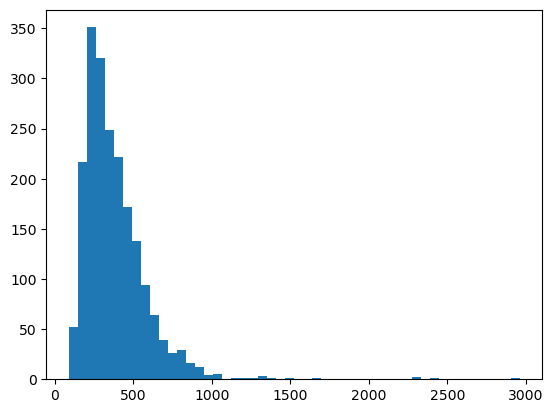

In [20]:
plt.hist([l for l in seq_lens if l < 3000], bins=50);

Let's truncate and pad all the sequences to 1000 symbols to build the training set:

In [21]:
from keras.preprocessing.sequence import pad_sequences


MAX_SEQUENCE_LENGTH = 1000

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (2025, 1000)
Shape of data test tensor: (200, 1000)


In [28]:
from keras.utils import to_categorical

y_train = to_categorical(target_train)
y_test = to_categorical(target_test)

print('Shape of label tensor:', y_train.shape)
print('Shape of label tensor (test):', y_test.shape)

Shape of label tensor: (2025, 5)
Shape of label tensor (test): (200, 5)


### A simple supervised CBOW model in Keras

The following computes a very simple model, as described in [fastText](https://github.com/facebookresearch/fastText):

<img src="images/fasttext.svg" style="width: 600px;" />

- Build an embedding layer mapping each word to a vector representation
- Compute the vector representation of all words in each sequence and average them
- Add a dense layer to output 20 classes (+ softmax)

In [33]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model
from keras import optimizers

EMBEDDING_DIM = 50
N_CLASSES = len(target_names)

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.01), metrics=['acc'])

In [34]:
model.fit(x_train, y_train, validation_split=0.1,
          epochs=10, batch_size=32)

Epoch 1/10
57/57 [==============================] - 2s 18ms/step - loss: 1.5973 - acc: 0.2640 - val_loss: 1.5833 - val_acc: 0.2759
Epoch 2/10
57/57 [==============================] - 1s 18ms/step - loss: 1.5614 - acc: 0.3227 - val_loss: 1.5488 - val_acc: 0.3695
Epoch 3/10
57/57 [==============================] - 1s 16ms/step - loss: 1.5148 - acc: 0.4682 - val_loss: 1.4991 - val_acc: 0.5172
Epoch 4/10
57/57 [==============================] - 1s 16ms/step - loss: 1.4515 - acc: 0.5554 - val_loss: 1.4265 - val_acc: 0.5468
Epoch 5/10
57/57 [==============================] - 1s 14ms/step - loss: 1.3701 - acc: 0.6158 - val_loss: 1.3403 - val_acc: 0.6158
Epoch 6/10
57/57 [==============================] - 1s 14ms/step - loss: 1.2768 - acc: 0.6894 - val_loss: 1.2468 - val_acc: 0.6897
Epoch 7/10
57/57 [==============================] - 1s 14ms/step - loss: 1.1765 - acc: 0.7184 - val_loss: 1.1481 - val_acc: 0.7340
Epoch 8/10
57/57 [==============================] - 1s 15ms/step - loss: 1.0733 - a

**Exercices**

- Compute model accuracy on test set

In [35]:
# Verify your solution by a tutor.
loss, accuracy = model.evaluate(x_test, y_test)
print("Test accuracy:", accuracy)


7/7 [==============================] - 0s 4ms/step - loss: 0.8963 - acc: 0.8400
Test accuracy: 0.8399999737739563


### Building more complex models

**Exercise**
- From the previous template, build more complex models using:
  - **1d convolution and 1d maxpooling**. Note that you will still need a GloabalAveragePooling or Flatten after the convolutions as the final `Dense` layer expects a fixed size input;
  - **Recurrent neural networks through LSTM** (you will need to **reduce sequence length before using the LSTM layer**).

  
<img src="images/unrolled_rnn_one_output_2.svg" style="width: 600px;" />

**Bonus**
- You may try different architectures with:
  - more intermediate layers, combination of dense, conv, recurrent
  - different recurrent (GRU, RNN)
  - bidirectional LSTMs

**Note**: The goal is to build working models rather than getting better test accuracy as this task is already very well solved by the simple model.  Build your model, and verify that they converge to OK results.

In [36]:
from keras.layers import Embedding, Dense, Input, Flatten
from keras.layers import Conv1D, LSTM, GRU
from keras.layers import MaxPooling1D, GlobalAveragePooling1D 
from keras.models import Model

EMBEDDING_DIM = 50
N_CLASSES = len(target_names)

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [37]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

conv1d = Conv1D(128, 5, activation='relu')(embedded_sequences)
maxpool = MaxPooling1D(5)(conv1d)
average = GlobalAveragePooling1D()(maxpool)

predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

# Train the model
model.fit(x_train, y_train, validation_split=0.1,
          epochs=15, batch_size=32)

# Test accuracy
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test accuracy (Conv1D):", test_accuracy)



Epoch 1/15
57/57 [==============================] - 6s 81ms/step - loss: 1.5641 - acc: 0.3282 - val_loss: 1.4812 - val_acc: 0.5320
Epoch 2/15
57/57 [==============================] - 4s 76ms/step - loss: 1.2166 - acc: 0.6608 - val_loss: 0.9058 - val_acc: 0.7340
Epoch 3/15
57/57 [==============================] - 4s 78ms/step - loss: 0.6263 - acc: 0.8699 - val_loss: 0.4238 - val_acc: 0.9557
Epoch 4/15
57/57 [==============================] - 4s 71ms/step - loss: 0.2811 - acc: 0.9654 - val_loss: 0.2197 - val_acc: 0.9803
Epoch 5/15
57/57 [==============================] - 4s 72ms/step - loss: 0.1374 - acc: 0.9874 - val_loss: 0.1385 - val_acc: 0.9704
Epoch 6/15
57/57 [==============================] - 4s 74ms/step - loss: 0.0767 - acc: 0.9934 - val_loss: 0.1067 - val_acc: 0.9754
Epoch 7/15
57/57 [==============================] - 4s 76ms/step - loss: 0.0472 - acc: 0.9956 - val_loss: 0.0912 - val_acc: 0.9754
Epoch 8/15
57/57 [==============================] - 4s 74ms/step - loss: 0.0304 - a

In [38]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

# LSTM layer
lstm = LSTM(64)(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

# Define and compile the model
model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

# Train the model
model.fit(x_train, y_train, validation_split=0.1,
          epochs=15, batch_size=32)

# Test accuracy
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test accuracy (LSTM):", test_accuracy)



ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 1000), dtype=tf.int32, name='input_6'), name='input_6', description="created by layer 'input_6'") at layer "embedding_5". The following previous layers were accessed without issue: []

In [39]:
model.fit(x_train, y_train, validation_split=0.1,
          epochs=15, batch_size=32)

output_test = model(x_test)
test_casses = np.argmax(output_test, axis=-1)
print("Test accuracy:", np.mean(test_casses == target_test))

Epoch 1/15
57/57 [==============================] - 4s 75ms/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0630 - val_acc: 0.9803
Epoch 2/15
57/57 [==============================] - 4s 73ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0642 - val_acc: 0.9803
Epoch 3/15
57/57 [==============================] - 4s 74ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0641 - val_acc: 0.9803
Epoch 4/15
57/57 [==============================] - 4s 74ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0641 - val_acc: 0.9803
Epoch 5/15
57/57 [==============================] - 4s 78ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0636 - val_acc: 0.9803
Epoch 6/15
57/57 [==============================] - 4s 76ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0636 - val_acc: 0.9803
Epoch 7/15
57/57 [==============================] - 4s 77ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0642 - val_acc: 0.9803
Epoch 8/15
57/57 [==============================] - 4s 74ms/step - loss: 0.0016 - a

### Loading pre-trained embeddings

The file `glove100K.100d.txt` is an extract of [Glove](http://nlp.stanford.edu/projects/glove/) Vectors, that were trained on english Wikipedia 2014 + Gigaword 5 (6B tokens).

We extracted the `100 000` most frequent words. They have a dimension of `100`

In [1]:
embeddings_index = {}
embeddings_vectors = []
with open('glove100K.100d.txt', 'rb') as f:
    word_idx = 0
    for line in f:
        values = line.decode('utf-8').split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = word_idx
        embeddings_vectors.append(vector)
        word_idx = word_idx + 1

inv_index = {v: k for k, v in embeddings_index.items()}
print("found %d different words in the file" % word_idx)

FileNotFoundError: [Errno 2] No such file or directory: 'glove100K.100d.txt'

In [ ]:
# Stack all embeddings in a large numpy array
glove_embeddings = np.vstack(embeddings_vectors)
glove_norms = np.linalg.norm(glove_embeddings, axis=-1, keepdims=True)
glove_embeddings_normed = glove_embeddings / glove_norms
print(glove_embeddings.shape)

In [ ]:
def get_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return None
    else:
        return glove_embeddings[idx]

    
def get_normed_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return None
    else:
        return glove_embeddings_normed[idx]

In [ ]:
get_emb("computer")

### Finding most similar words

**Exercice**

Build a function to find most similar words, given a word as query:
- lookup the vector for the query word in the Glove index;
- compute the cosine similarity between a word embedding and all other words;
- display the top 10 most similar words.

**Bonus**

Change your function so that it takes multiple words as input (by averaging them)

In [40]:
# Verify your solution by a tutor.
def most_similar(word, top_n=10):
    word_emb = get_normed_emb(word)
    if word_emb is None:
        return []
    similarity = np.dot(glove_embeddings_normed, word_emb)
    similar_idxs = np.argsort(similarity)[::-1][:top_n]
    return [(inv_index[i], similarity[i]) for i in similar_idxs]


In [41]:
most_similar("cpu")

NameError: name 'get_normed_emb' is not defined

In [ ]:
most_similar("pitt")

In [ ]:
most_similar("jolie")

Predict the future better than tarot:

In [ ]:
np.dot(get_normed_emb('aniston'), get_normed_emb('pitt'))

In [ ]:
np.dot(get_normed_emb('jolie'), get_normed_emb('pitt'))

In [ ]:
most_similar("1")

In [ ]:
# bonus: sum of two word embeddings
most_similar(["river", "chinese"])

### Displaying vectors with  t-SNE


In [ ]:
from sklearn.manifold import TSNE

word_emb_tsne = TSNE(perplexity=30).fit_transform(glove_embeddings_normed[:1000])

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 40))
axis = plt.gca()
np.set_printoptions(suppress=True)
plt.scatter(word_emb_tsne[:, 0], word_emb_tsne[:, 1], marker=".", s=1)

for idx in range(1000):
    plt.annotate(inv_index[idx],
                 xy=(word_emb_tsne[idx, 0], word_emb_tsne[idx, 1]),
                 xytext=(0, 0), textcoords='offset points')
plt.savefig("tsne.png")
plt.show()

### Using pre-trained embeddings in our model

We want to use these pre-trained embeddings for transfer learning. This process is rather similar than transfer learning in image recognition: the features learnt on words might help us bootstrap the learning process, and increase performance if we don't have enough training data.
- We initialize embedding matrix from the model with Glove embeddings:
 - take all unique words from our BBC news dataset to build a vocabulary (`MAX_NB_WORDS = 20000`), and look up their Glove embedding 
 - place the Glove embedding at the corresponding index in the matrix
 - if the word is not in the Glove vocabulary, we only place zeros in the matrix
- We may fix these embeddings or fine-tune them

In [ ]:
EMBEDDING_DIM = 100

# prepare embedding matrix
nb_words_in_matrix = 0
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = get_emb(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        nb_words_in_matrix = nb_words_in_matrix + 1
        
print("added %d words in the embedding matrix" % nb_words_in_matrix)

Build a layer with pre-trained embeddings:

In [ ]:
pretrained_embedding_layer = Embedding(
    MAX_NB_WORDS, EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
)

### A model with pre-trained Embeddings

Average word embeddings pre-trained with Glove / Word2Vec usually works surprisingly well. However, when averaging more than `10-15` words, the resulting vector becomes too noisy and classification performance is degraded.

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = pretrained_embedding_layer(sequence_input)
average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)

# We don't want to fine-tune embeddings
model.layers[1].trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.01), metrics=['acc'])

In [ ]:
model.fit(x_train, y_train, validation_split=0.1,
          epochs=15, batch_size=32)
loss, accuracy = model.evaluate(x_test, y_test)

**Remarks:**

- On this type of task, using pre-trained embeddings can degrade results as we train much less parameters and we average a large number pre-trained embeddings.

- Pre-trained embeddings followed by global averaging prevents overfitting but can also cause some underfitting.

- Using convolutions / LSTM should help counter the underfitting effect.

- It is also advisable to treat separately pre-trained embeddings and words out of vocabulary.

Pre-trained embeddings can be very useful when the training set is small and the individual text documents to classify are short: in this case there might be a single very important word in a test document that drives the label. If that word has never been seen in the training set but some synonyms were seen, the semantic similarity captured by the embedding will allow the model to generalized out of the restricted training set vocabulary.

We did not observe this effect here because the document are long enough so that guessing the topic can be done redundantly. Shortening the documents to make the task more difficult could possibly highlight this benefit.

### Reality check

On small/medium datasets (few 10,000s) of reasonably large documents (e.g. more than a few paragraphs), simpler classification methods usually perform better, and are much more efficient to train and use. Here are two resources to go further:
- Naive Bayes approach, using scikit-learn http://scikit-learn.org/stable/datasets/twenty_newsgroups.html
- Alec Radford (OpenAI) gave a very interesting presentation, showing that you need a VERY large dataset to have real gains from GRU/LSTM in text classification https://www.slideshare.net/odsc/alec-radfordodsc-presentation

Training deep architectures from random init on text classification is usually a waste of time.

However, when looking at features, one can see that classification using simple methods isn't very robust, and won't generalize well to slightly different domains (e.g. forum posts => emails)

Nowadays, the strategy would be to use pre-trained deep network (BERT) to extract features and fit a linear classifer on top of this. This is especially useful when classifying short texts (e.g. one or a few sentences) as this kind of tasks can be very sensitive to understanding the meaning resulting from intra-sentence interactions between words. The next session on attentional mechanisms and pre-trained transformer-based word models will explain this in more details.

## Going further

- Compare pre-trained embeddings vs specifically trained embeddings
- Train your own wordvectors in any language using [gensim's word2vec](https://radimrehurek.com/gensim/models/word2vec.html)
- Check [Keras Examples](https://github.com/fchollet/keras/tree/master/examples) on `imdb` sentiment analysis
- Install fastText (Linux or macOS only, use the Linux VM if under Windows) and give it a try on the classification example in its repository.
- Today, the **state-of-the-art text classification** can be achieved by **transfer learning from a language model** instead of using traditional word embeddings. See for instance: [ULMFit, Fine-tuned Language Models for Text Classification](https://arxiv.org/abs/1801.06146), [ELMO](https://allennlp.org/elmo), [GPT](https://blog.openai.com/language-unsupervised/), [BERT](https://arxiv.org/abs/1810.04805), [GPT-2](https://github.com/openai/gpt-2). The second notebook introduces how to train such a language model from unlabeled data.